<h1 align="center">Mathematical Methods in Engineering - Course Code: 25872</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2023</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Questions 1 & 2: [Zahra maleki](https://t.me/Rosebaekfany), Questions 3: [Radin Khayyam](https://t.me/Radinkhayyam)

</h4>

<p>
    Write your code in the <span style="color: green;">Code Cell</span> and run the <span style="color: green;">Evaluation Cell</span> to check the output.<br>
    <span style="color: red; font-weight: bold;">Please refrain from editing the existing codes.</span>
</p>


In [ ]:
Name = "AmirReza Zameni"
Student_Number = ""

### Importing necessary libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from PIL import Image
import time
from numpy import asarray
from sklearn.utils.extmath import randomized_svd
import requests

In [ ]:
np.random.RandomState(0)

RandomState(MT19937) at 0x7EA500A77D40

In [2]:
def plot_multiple_r2_on_same_axis(train_test_ratios, r2_values_list, labels,ylim,x_label,y_label,title,log):

    assert len(r2_values_list) == len(labels), "Number of R² value vectors must match the number of labels"
    plt.figure(figsize=(10, 6))
    for i, r2_values in enumerate(r2_values_list):
        if(log==0):
            plt.plot(train_test_ratios, r2_values,marker='o', label=labels[i])
        elif(log==1):
            plt.semilogx(train_test_ratios, r2_values,marker='o', label=labels[i])
        elif(log==2):
            plt.semilogx(train_test_ratios, r2_values, label=labels[i])
        elif(log==3):
            plt.semilogy(train_test_ratios, r2_values, label=labels[i])
        elif(log==4):
            plt.plot(train_test_ratios, r2_values, label=labels[i])
        elif(log==5):
            plt.loglog(train_test_ratios, r2_values, label=labels[i])
    plt.xlabel(x_label)#'Train Ratio')
    plt.ylabel(y_label)#'R² Value')
    plt.title(title)#'R² vs. Train Ratio')
    plt.ylim(ylim)
    plt.grid(True)
    plt.legend()
    plt.show()
def multyx(arr):
    arr.reverse()
    res=arr[0]
    for i in range(len(arr)-1):
        res=np.matmul(arr[i+1],res)
    return res

## Problem 1: SVD for Compression ``(35 pt.)``

In this question, we want to compress BMP images using SVD. BMP images are not compressed by default and the pixel information is stored in rather a simple format. Colored BMP files are composed of three matrices of size $n × m$ where $n$ and $m$ are the height and width of the image, respectively. Each matrix corresponds to one of the three colors Red, Green, and Blue. Each entry of these matrices is a number between 0 and 255 that specifies the intensity of the corresponding color. The final array is hence a 3D array of size $n × m × 3$.

### 1.1 Image display
Choose two arbitrary BMP files (it is recommended to use different subjects and sizes) and load it into a `numpy` array using the `imread` function. Then, show each image and display their shape.

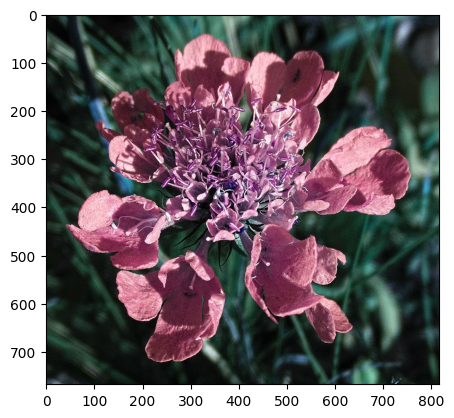

image shape : 
(768, 817, 3)


In [ ]:
# Code cell
Q4_image = cv2.imread('flower.jpg')
plt.imshow(Q4_image)
plt.show()
print("image shape : ")
print(Q4_image.shape)


In [ ]:
def plot_images_with_titles(image_array,ks):
    """
    Plots a set of images with integer titles.

    Args:
        image_array (np.ndarray): A 4D numpy array containing the images. The shape should be (n, height, width, channels).

    Returns:
        None
    """
    n_images = image_array.shape[0]
    rows = (n_images + 1) // 2  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, 2, figsize=(12, 6 * rows))

    for i in range(n_images):
        row_idx = i // 2
        col_idx = i % 2

        axes[row_idx, col_idx].imshow(image_array[i])
        axes[row_idx, col_idx].set_title(str(ks[i]))  # Integer title
        axes[row_idx, col_idx].axis('off')  # Hide axis

    # Hide any remaining empty subplots
    for j in range(n_images, rows * 2):
        axes[j // 2, j % 2].axis('off')

    plt.show()

### 1.2 Singular Value Decomposition and channel seperation

Calculate the SVD decomposition of each of ech RGB channel.

$$
A = U \Sigma V^T
$$
where $A$ is the original array, $U$ is an $n × n$ unitary matrix, $\Sigma$ is an $n × m$ rectangular diagonal matrix with non-negative real numbers on the diagonal, and $V$ is an $m × m$ unitary matrix.

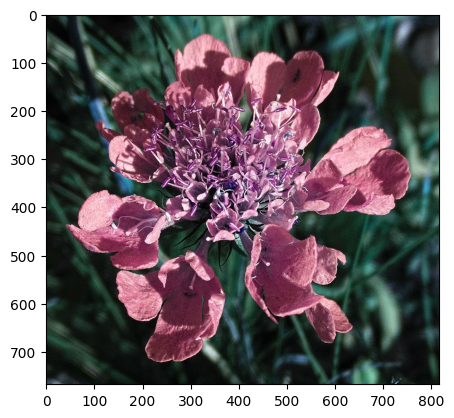

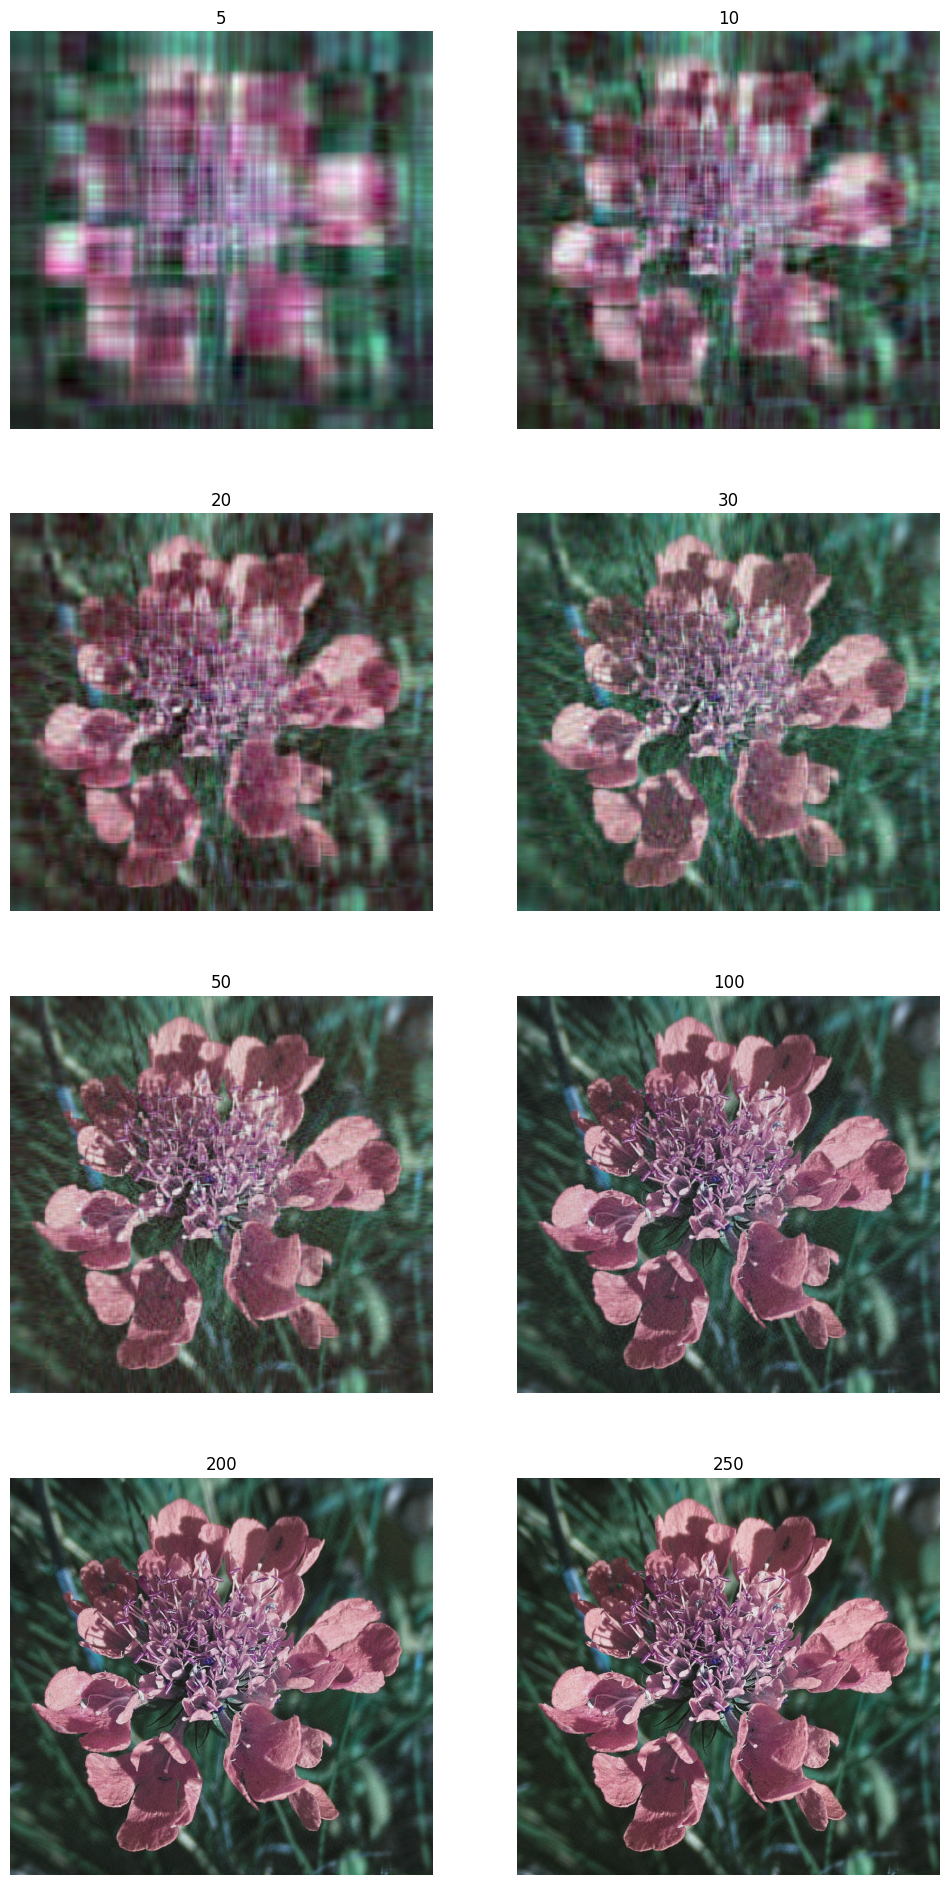

In [ ]:
# Code cell
def normalize(im):
   # Normalise image to range 0..1
    min, max = im.min(), im.max()
    return (im.astype(float)-min)/(max-min)
ks=[5, 10, 20, 30, 50, 100, 200, 250]
ks_np=np.array(ks)
n=len(ks)

pic_list=[]
pic1=cv2.imread('flower.jpg')

for i in range(n):
    pic_list=pic_list+[pic1]
    #print(pic_list[i].shape)
SVDs_list= [[]  for _ in range(n)]
compressed_list=[]
pic_indx=0
for i in pic_list:
    test_mat=[]
    for j in range(3):
        #print(i[j,:,:].shape)
        U,S,Vh=np.linalg.svd(i[:,:,j])
        mat_val=np.diag(S)
        on,tw,tr=compress_by_k(ks_np[pic_indx],U,mat_val,Vh)
        test_mat=test_mat+[multyx([on,tw,tr])]
        SVDs_list[pic_indx]=SVDs_list[pic_indx]+[U,S,Vh]

    compressed_list=compressed_list+[np.dstack((normalize(test_mat[0]),normalize( test_mat[1]), normalize( test_mat[2])))]
    pic_indx=pic_indx+1
plt.imshow(pic1)
#plt.imshow(test_mat[0])
plot_images_with_titles(np.array(compressed_list),ks_np)

### 1.3 compressing the image

Since eigenvalues in the decomposition are sorted in descending order, we can approximate the original array by keeping only the first $k$ columns of $U$, first $k$ rows and columns of $\Sigma$, and first $k$ rows of $V^T$.
Select $k$ to be (5, 10, 20, 30, 50, 100, 200, 250) and approximate the original array using the truncated SVD. Show the approximated image titled with the value of $k$.

In [ ]:
# Code cell
def compress_by_k(k,U1,S1,V1):
    return U1[:,:k],S1[:k,:k],V1[:k,:]


#### explion your results.

Explain the relationship between the number of components and the level of compression in the images. How does the image quality change with increasing values of k?
<br>
For each component, we need to store two vectors with m+n 8-bit integers and one integer as the singular value. There will be a maximum of min(m,n) non-zero components (equivalent to the matrix rank). Fewer components result in less memory usage. However, if we want to retain all components, it’s generally better to keep the entire matrix unless the matrix rank is significantly smaller than m and n (i.e., when r⋅(m+n+1) is less than m⋅n).
Typically, most of a matrix’s variance lies in a fraction of its singular values. Many singular values are very small and can be safely ignored without a noticeable loss in quality. By retaining only the corresponding vectors for large singular values and discarding the rest, we can compress the image without sacrificing much quality.
As illustrated in the graph, increasing k (the number of singular values retained) significantly affects image quality for the first few singular values. However, after around 150 singular values, the changes become barely noticeable.


### 1.4 variance

there is no need to store $U$ and $V$ matrices. Instead, we can store $\Sigma$ and two other matrices of size $n × k$ and $m × k$. Using $\Sigma$ display the plots below. To not compress the image based on a given random number k, we are required to do some math & statistics

1. The plot "Component Importance" shows the  amount  of variance each component carries. The first component preserves the highest variance, then the second, and so on.
2. The plot shows the explained variance as a function of numbers, using this technique you can choose how much the image, relative to its original size gets compressed.

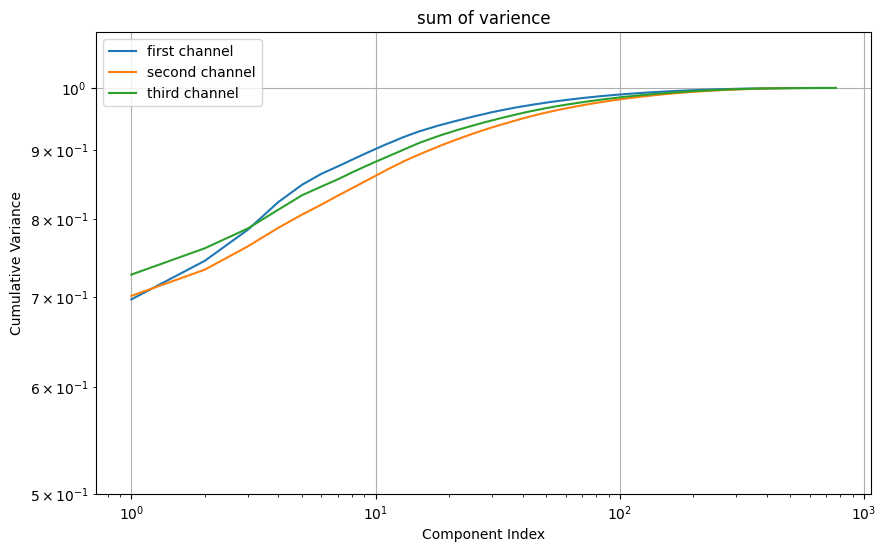

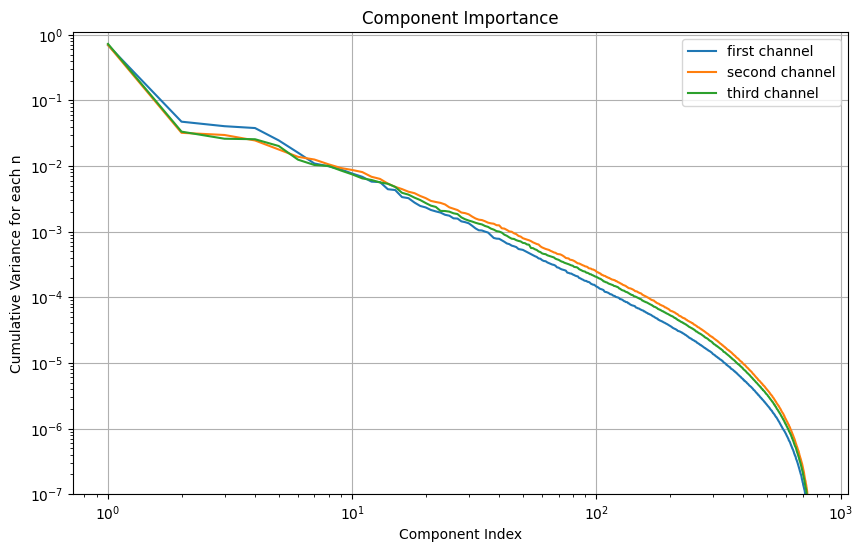

In [ ]:
# Code cell
Svds=[]
cumulative_variance = []
cumulative_variance_for_each = []
for i in range(3):
    _,S,_=np.linalg.svd(pic1[:,:,i])
    Svds=Svds+[S]
    cumulative_variance=cumulative_variance+[np.cumsum(S**2) / np.sum(S**2)]
    cumulative_variance_for_each=cumulative_variance_for_each+[(S**2) / np.sum(S**2)]

plot_multiple_r2_on_same_axis(range(1, len(cumulative_variance[0]) + 1),cumulative_variance,['first channel','second channel','third channel'],[5*10**(-1),1.1],'Component Index','Cumulative Variance','sum of varience',5)
plot_multiple_r2_on_same_axis(range(1, len(cumulative_variance_for_each[0]) + 1),cumulative_variance_for_each,['first channel','second channel','third channel'],[10**(-7),1.1],'Component Index','Cumulative Variance for each n','Component Importance',5)


Compress the image with 90% of its explained variance ratio and show the result image.
based on previos result n=120 is enough

Text(0.5, 1.0, 'compress by keeping 120')

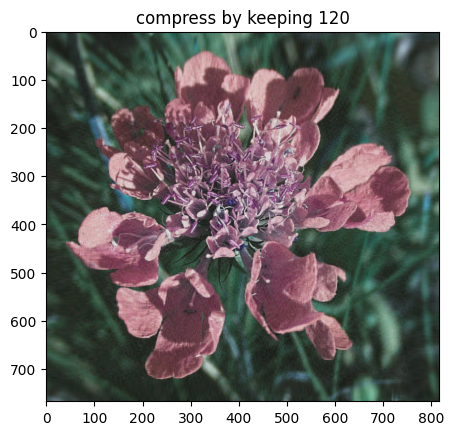

In [ ]:
# Code cell

test_mat=[]
for j in range(3):
        #print(i[j,:,:].shape)
        U,S,Vh=np.linalg.svd(pic1[:,:,j])
        mat_val=np.diag(S)
        on,tw,tr=compress_by_k(120,U,mat_val,Vh)
        test_mat=test_mat+[multyx([on,tw,tr])]
final_res_for_120=np.dstack((normalize(test_mat[0]),normalize( test_mat[1]), normalize( test_mat[2])))
plt.imshow(final_res_for_120)
plt.title("compress by keeping 120")


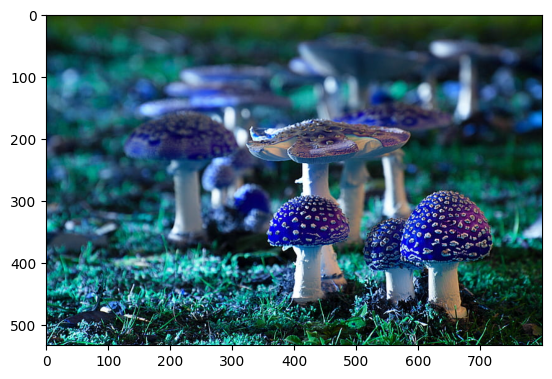

image shape : 
(533, 800, 3)


In [ ]:
# Code cell
Q4_image = cv2.imread('mushroom.jpg')
plt.imshow(Q4_image)
plt.show()
print("image shape : ")
print(Q4_image.shape)


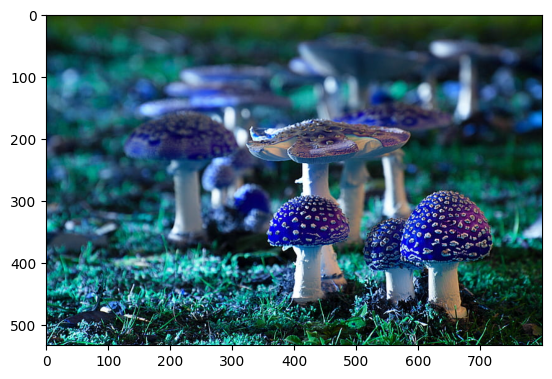

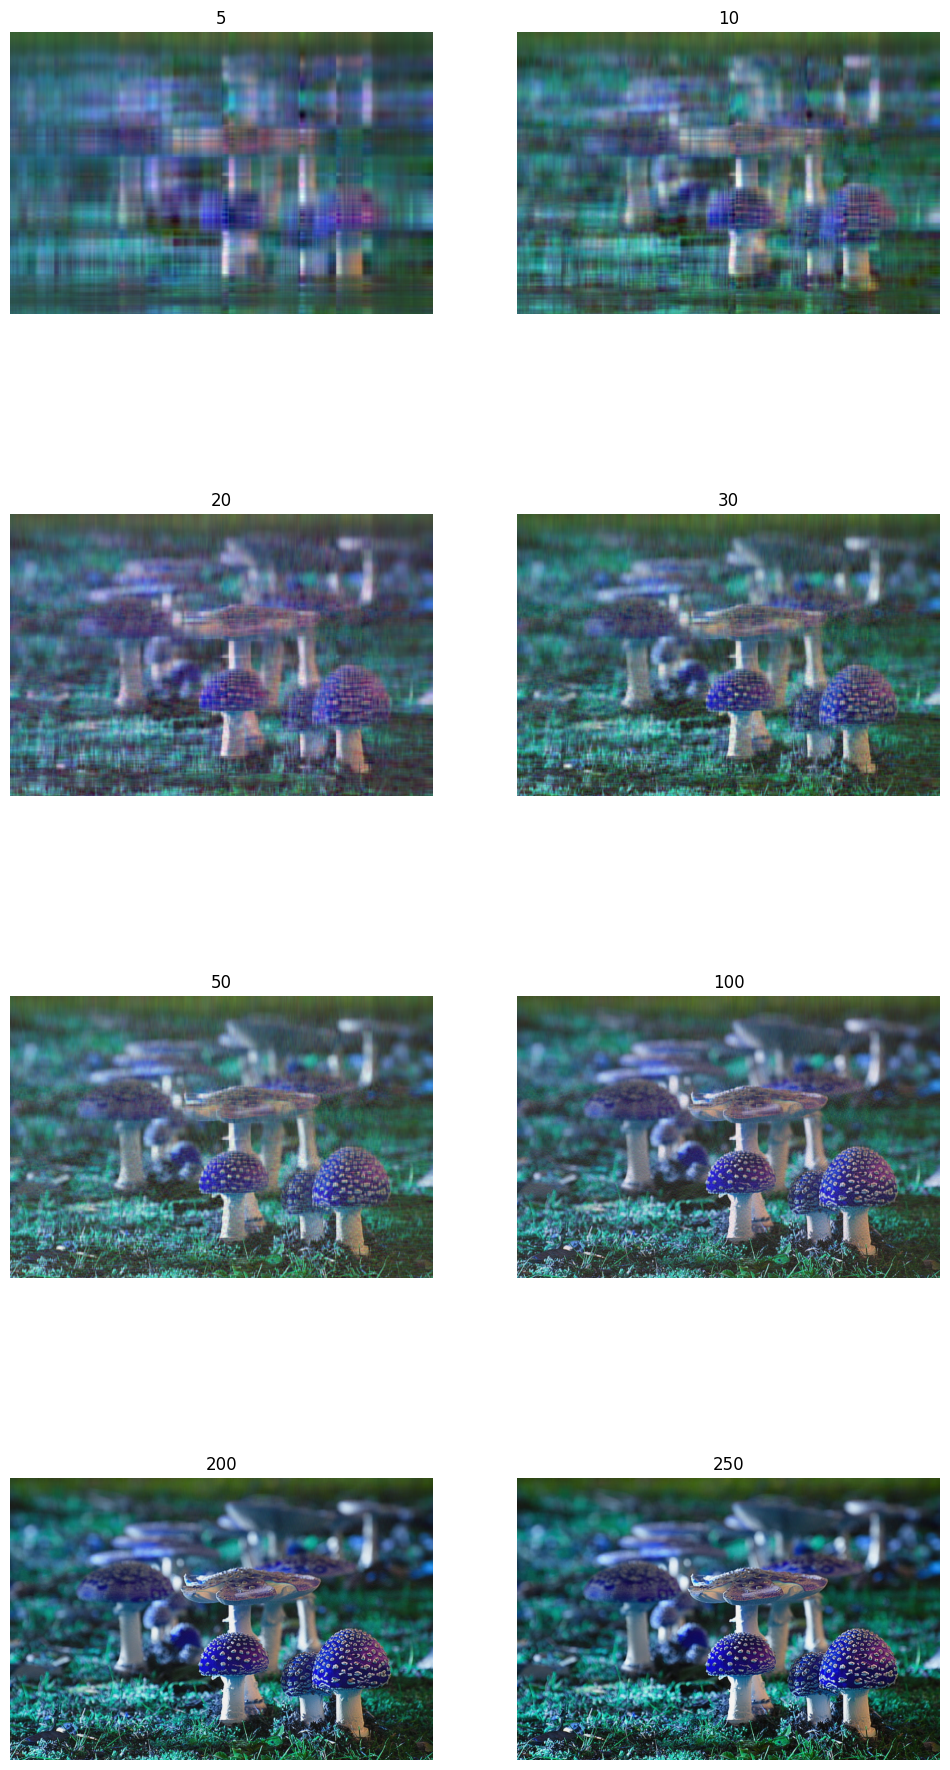

In [ ]:
# Code cell
def normalize(im):
   # Normalise image to range 0..1
    min, max = im.min(), im.max()
    return (im.astype(float)-min)/(max-min)
ks=[5, 10, 20, 30, 50, 100, 200, 250]
ks_np=np.array(ks)
n=len(ks)

pic_list=[]
pic1=cv2.imread('mushroom.jpg')

for i in range(n):
    pic_list=pic_list+[pic1]
    #print(pic_list[i].shape)
SVDs_list= [[]  for _ in range(n)]
compressed_list=[]
pic_indx=0
for i in pic_list:
    test_mat=[]
    for j in range(3):
        #print(i[j,:,:].shape)
        U,S,Vh=np.linalg.svd(i[:,:,j])
        mat_val=np.diag(S)
        on,tw,tr=compress_by_k(ks_np[pic_indx],U,mat_val,Vh)
        test_mat=test_mat+[multyx([on,tw,tr])]
        SVDs_list[pic_indx]=SVDs_list[pic_indx]+[U,S,Vh]

    compressed_list=compressed_list+[np.dstack((normalize(test_mat[0]),normalize( test_mat[1]), normalize( test_mat[2])))]
    pic_indx=pic_indx+1
plt.imshow(pic1)
#plt.imshow(test_mat[0])
plot_images_with_titles(np.array(compressed_list),ks_np)

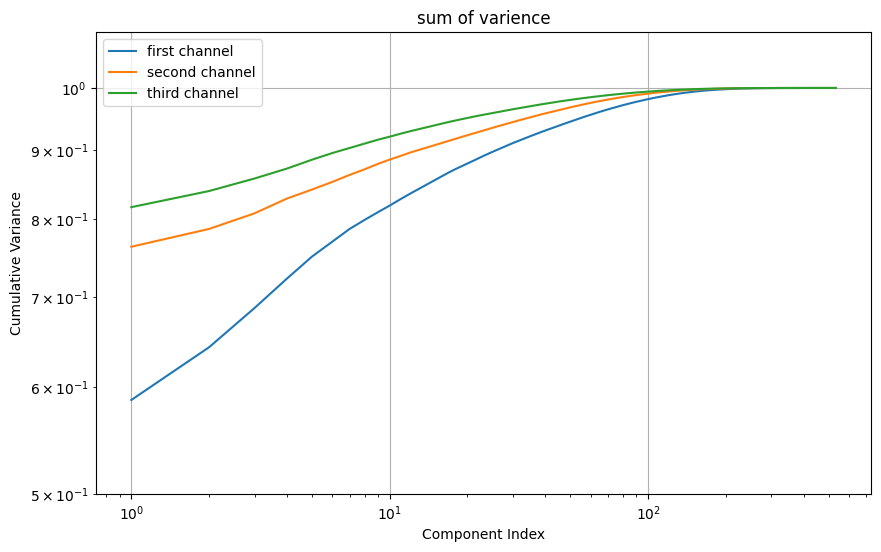

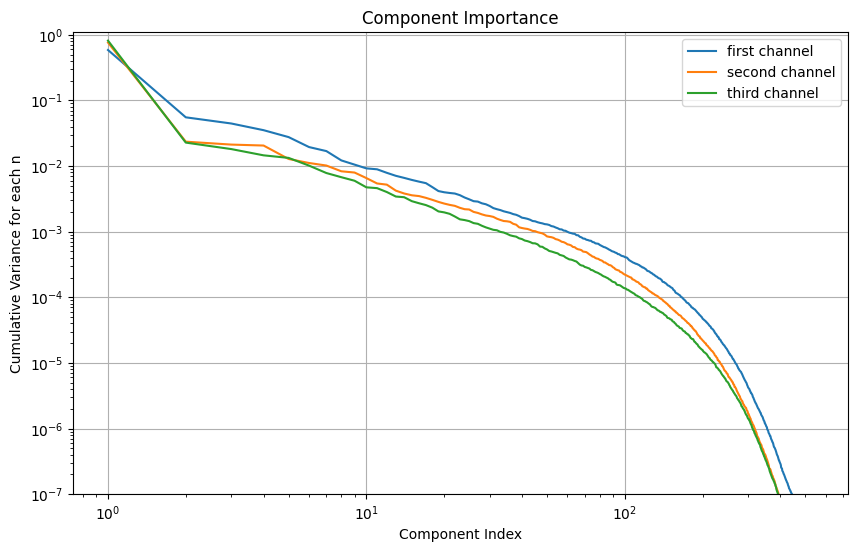

In [ ]:
# Code cell
Svds=[]
cumulative_variance = []
cumulative_variance_for_each = []
for i in range(3):
    _,S,_=np.linalg.svd(pic1[:,:,i])
    Svds=Svds+[S]
    cumulative_variance=cumulative_variance+[np.cumsum(S**2) / np.sum(S**2)]
    cumulative_variance_for_each=cumulative_variance_for_each+[(S**2) / np.sum(S**2)]

plot_multiple_r2_on_same_axis(range(1, len(cumulative_variance[0]) + 1),cumulative_variance,['first channel','second channel','third channel'],[5*10**(-1),1.1],'Component Index','Cumulative Variance','sum of varience',5)
plot_multiple_r2_on_same_axis(range(1, len(cumulative_variance_for_each[0]) + 1),cumulative_variance_for_each,['first channel','second channel','third channel'],[10**(-7),1.1],'Component Index','Cumulative Variance for each n','Component Importance',5)


Text(0.5, 1.0, 'compress by keeping 140')

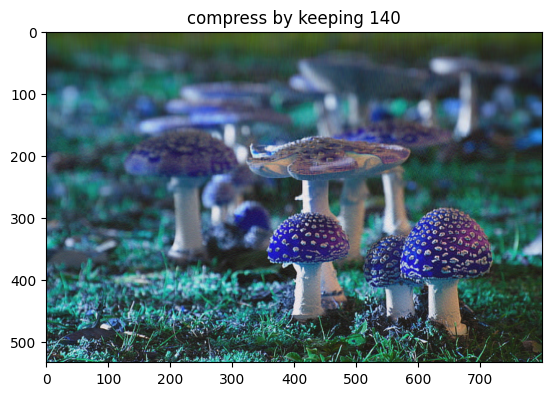

In [ ]:
# Code cell

test_mat=[]
for j in range(3):
        #print(i[j,:,:].shape)
        U,S,Vh=np.linalg.svd(pic1[:,:,j])
        mat_val=np.diag(S)
        on,tw,tr=compress_by_k(140,U,mat_val,Vh)
        test_mat=test_mat+[multyx([on,tw,tr])]
final_res_for_140=np.dstack((normalize(test_mat[0]),normalize( test_mat[1]), normalize( test_mat[2])))
plt.imshow(final_res_for_140)
plt.title("compress by keeping 140")


## Problem 2 ``(30 pt.)``

### 2.1 Truncate the SVD
Write the function of truncated_svd

In [3]:
# Code cell
def truncated_svd(matrix, k):

    # Compute the SVD of the matrix
    U, S, Vt = np.linalg.svd(matrix, full_matrices=False)
    return compress_by_k(k,U,S,Vt)

### 2.2 Randomized SVD

In the following cell, you should implement the randomized SVD for the input matrix. The number of empty lines below suggests the number of lines needed for a possible solution.

In [4]:
def sqr(A):
    Q, R = linalg.qr(A,mode="economic")
    return Q, R

In [5]:
# This function performs randomized svd using linalg from scipy
def rsvd(A, n_components, random_state, n_oversamples, n_iter):
  # Sample column space of X with P matrix
  ny = A.shape[1]
  # TODO: set the random state of numpy
  ######### your code here #########
  np.random.RandomState(random_state)

  ##################################
  # TODO: Generate a random matrix P of shape (ny,n_components+n_oversamples)
  ######### your code here #########
  P =  np.random.standard_normal((ny, n_components + n_oversamples))
  ##################################
  Z = multyx([A,P])
  # TODO: for n_iter iterations, computes A multiplied by A transpose multiplied by Z
  ######### your code here #########
  for _ in range(int(n_iter/2)):
        Z = multyx([A , A.T , Z])


  ##################################
  Q,R = sqr(Z)
  # Step 2: Compute SVD on projected Y = Q.T @ X, name them U1,S,VT
  ######### your code here #########
  Y = multyx([Q.T , A])
  U1, S, VT = linalg.svd(Y)
  ##################################
  U = multyx([Q , U1])

  return U[:, :n_components], S[:n_components], VT[:n_components, :]


In [6]:
import scipy.linalg

def matrix_multiply_lu(A, B):
    """
    Computes matrix multiplication AB using LU decomposition of matrix A.

    Args:
        A (np.ndarray): The input matrix A.
        B (np.ndarray): The matrix to multiply with A.

    Returns:
        np.ndarray: The resulting matrix AB.
    """
    # Perform LU decomposition of A
    P, L, U = scipy.linalg.lu(A)

    # Solve the system of equations LUx = B
    ux = scipy.linalg.solve_triangular(L, np.matmul(P.T, B), lower=True)
    x = scipy.linalg.solve_triangular(U,  ux, lower=False)


    # Compute AB
    AB = np.dot(A, x)

    return AB


In the following cell, implement the rsvd as you did before but this time use the LU decomposition instead of the multiplication of matrices.

In [18]:
# Using lu insted of multiplication (can be quite unstable try different random seeds if needed)
def nrsvd(A, n_components, random_state, n_oversamples, n_iter):
  ######### your code here #########
  ny = A.shape[1]
  # TODO: set the random state of numpy
  ######### your code here #########
  np.random.RandomState(random_state)

  ##################################
  # TODO: Generate a random matrix P of shape (ny,n_components+n_oversamples)
  ######### your code here #########
  P =  np.random.standard_normal((ny, n_components + n_oversamples))
  ##################################
  Z = multyx([A,P])
  # TODO: for n_iter iterations, computes A multiplied by A transpose multiplied by Z
  ######### your code here #########
  for _ in range(int(n_iter/2)):
    #Z=matrix_multiply_lu(A,matrix_multiply_lu(A.T,Z))
        Z = multyx([A , A.T , Z])


  ##################################
  Q,R = sqr(Z)
  # Step 2: Compute SVD on projected Y = Q.T @ X, name them U1,S,VT
  ######### your code here #########
  Y = multyx([Q.T , A])
  U1, S, VT = linalg.svd(Y)
  ##################################
  U = multyx([Q , U1])
  ##################################
  return U[:, :n_components], S[:n_components], VT[:n_components, :]


This function performs the randomized SVD of sklearn library. Do not change this cell.

In [8]:
def srsvd(A, n_components, random_state, n_oversamples, n_iter):
  U, s, Vh = randomized_svd(A, n_components=n_components, random_state=random_state, n_oversamples=n_oversamples, n_iter=n_iter)
  return U[:, :n_components], s[:n_components], Vh[:n_components, :]

In order to test your randomized SVD code, please run the following cell. It contains test cases to verify the correctness of your implementation.

In [9]:
def make_matrix(m,n,k,randomstate):
    n_rows = m
    n_cols = n
    t = int(n_rows*n_cols*k)
    np.random.RandomState(randomstate)
    rr = np.random.choice(np.arange(0,n_rows),t)
    cr = np.random.choice(np.arange(0,n_cols),t)
    M = np.zeros((n_rows,n_cols))
    M[rr,cr]= 1
    return M

def base_rsvd(rsvdscipy,att):
  err = [0]*len(att)
  tim = [0]*len(att)
  for i in range(len(att)):
    M = make_matrix(att[i][0],att[i][1],0.01,att[i][3])
    start_time = time.time()
    U, s, Vh = rsvdscipy(M,att[i][2],att[i][3],att[i][4],att[i][5])
    time_length = time.time() - start_time
    M_rec = U @ np.diag(s) @ Vh
    error = np.linalg.norm(M - M_rec, ord='fro')/np.linalg.norm(M, ord='fro')
    err[i] = error
    tim[i] = time_length
    print(f"srsvd test {i+1}: error: {error:.3f}, time: {time_length:.3f}")
  print("-------------------------------")
  return err,tim

def test_rsvd(rsvdscipy,svd1):
  r=0
  att = [(3000,3000,500,r,10,4),(1500,1400,500,r,10,5),(2000,5000,400,r,10,7),(6000,2600,400,r,10,3)]
  err,tim = base_rsvd(rsvdscipy,att)
  for i in range(4):
    M = make_matrix(att[i][0],att[i][1],0.01,att[i][3])
    start_time = time.time()
    U, s, Vh = svd1(M,att[i][2],att[i][3],att[i][4],att[i][5])
    time_length = time.time() - start_time
    M_rec = U @ np.diag(s) @ Vh
    error = np.linalg.norm(M - M_rec, ord='fro')/np.linalg.norm(M, ord='fro')
    if error > err[i]+0.1:
      print(f"Test{i+1}, Alg rsvd: \033[31mFailed!\033[0m because of error \n with Error {error:.3f} and time {time_length:.3f} \n ------------------")
    elif time_length > tim[i]+0.5:
      print(f"Test{i+1}, Alg rsvd: \033[31mFailed!\033[0m because of time \n with Error {error:.3f} and time {time_length:.3f} \n ------------------")
    else:
      print(f"Test{i+1}, Alg rsvd: \033[32mPassed!\033[0m \n with Error {error:.3f} and time {time_length:.3f} \n ------------------")

In [11]:
test_rsvd(srsvd,rsvd)

srsvd test 1: error: 0.728, time: 6.358
srsvd test 2: error: 0.486, time: 2.598
srsvd test 3: error: 0.769, time: 8.570
srsvd test 4: error: 0.823, time: 5.151
-------------------------------
Test1, Alg rsvd: Passed! 
 with Error 0.742 and time 5.472 
 ------------------
Test2, Alg rsvd: Passed! 
 with Error 0.502 and time 1.775 
 ------------------
Test3, Alg rsvd: Passed! 
 with Error 0.779 and time 7.963 
 ------------------
Test4, Alg rsvd: Passed! 
 with Error 0.846 and time 5.439 
 ------------------


Here you can visualize the result of various svd methods on a cat image. You can also compare the time it takes for each method to run.

In [12]:
url = 'https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg?cs=srgb&dl=pexels-pixabay-45201.jpg&fm=jpg'
img = Image.open(requests.get(url, stream=True).raw)

rgb_image = asarray(img)
gray_image = np.average(rgb_image, axis=2, weights=[0.2989, 0.5870, 0.1140])

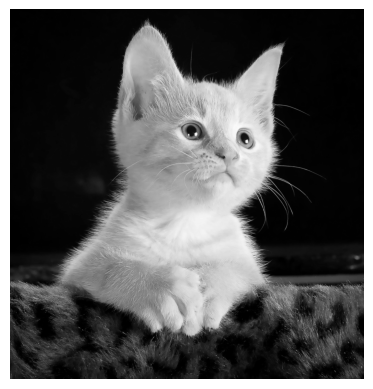

In [13]:
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

In [15]:
def show_images(im,k):
  start_time = time.time()
  U, s, Vh = linalg.svd(im)
  image1 = U[:, :k] @ np.diag(s[:k]) @ Vh[:k, :]
  t1 = time.time()-start_time
  start_time = time.time()
  U, s, Vh = rsvd(im,k,0,10,4)
  image2 = U @ np.diag(s) @ Vh
  t2 = time.time()-start_time
  start_time = time.time()
  U, s, Vh = nrsvd(im,k,0,10,4)
  image3 = U @ np.diag(s) @ Vh
  t3 = time.time()-start_time
  start_time = time.time()
  U, s, Vh = srsvd(im,k,0,10,4)
  image4 = U @ np.diag(s) @ Vh
  t4 = time.time()-start_time

  fig, axes = plt.subplots(nrows=2, ncols=2)

  axes[0, 0].imshow(image1, cmap='gray')
  axes[0, 0].set_title(f'svd, t = {t1:.2f}s')
  axes[0, 0].axis('off')
  axes[0, 1].imshow(image2, cmap='gray')
  axes[0, 1].set_title(f'rsvd, t = {t2:.2f}s')
  axes[0, 1].axis('off')
  axes[1, 0].imshow(image3, cmap='gray')
  axes[1, 0].set_title(f'nrsvd, t = {t3:.2f}s')
  axes[1, 0].axis('off')
  axes[1, 1].imshow(image4, cmap='gray')
  axes[1, 1].set_title(f'srsvd, t = {t4:.2f}s')
  axes[1, 1].axis('off')

  plt.tight_layout()
  plt.show()


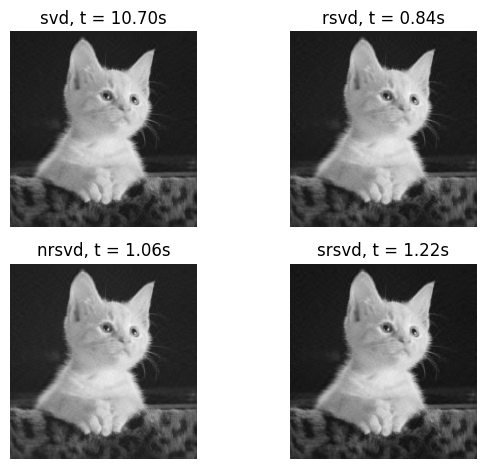

In [19]:
show_images(gray_image,50)

## Problem 3: PCA and its applications ``(50 pt.)``


Principal Component Analysis (PCA) is a statistical technique commonly used in data analysis and machine learning for dimensionality reduction while preserving as much variance as possible. It helps in identifying patterns in data based on the correlation between features. The goal of PCA is to reduce the number of variables of a data set, while preserving as much information (variance) as possible.

### Step 1: Standardize the Dataset
Normalize each feature in the dataset to have zero mean and unit variance to ensure each feature contributes equally:

\begin{align}
z_i = \frac{(x_i - \mu)}{\sigma}
\end{align}

### Step 2: Compute the Covariance Matrix
Construct a covariance matrix to analyze how features vary from the mean with respect to each other, which helps in identifying correlated features:

\begin{align}
C = \frac{1}{n-1} \times (X^T X)
\end{align}

where \( X \) is the standardized data matrix.

### Step 3: Calculate Eigenvalues and Eigenvectors
Solve for eigenvalues and their corresponding eigenvectors of the covariance matrix; these will determine the new axes (principal components) for the data projection:

\begin{align}
Cv = \lambda v
\end{align}

### Step 4: Sort Eigenvalues and Eigenvectors
Order the eigenvalues from largest to smallest and rank the eigenvectors accordingly. This ranking indicates the relative significance of each principal component.

### Step 5: Project Data onto Principal Components
Transform the original dataset into a new coordinate system by projecting it onto the principal eigenvectors, reducing dimensionality while retaining most of the variance:

\begin{align}
Y = XW
\end{align}

Here, \( W \) is the matrix containing the selected eigenvectors, and \( Y \) is the transformed data matrix. This final transformation results in a new dataset that highlights the most significant relationships within the original data.

---
In the section below, import all the libraries you need:

In [ ]:
# Code cell

The MNIST dataset is a large collection of handwritten digits commonly used for training various image processing systems. It contains 70,000 images of handwritten digits from 0 to 9, each represented as a 28x28 pixel grayscale image.

load the dataset and show the first 50 samples:

In [ ]:
#load the data set and fill nan value with 0
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


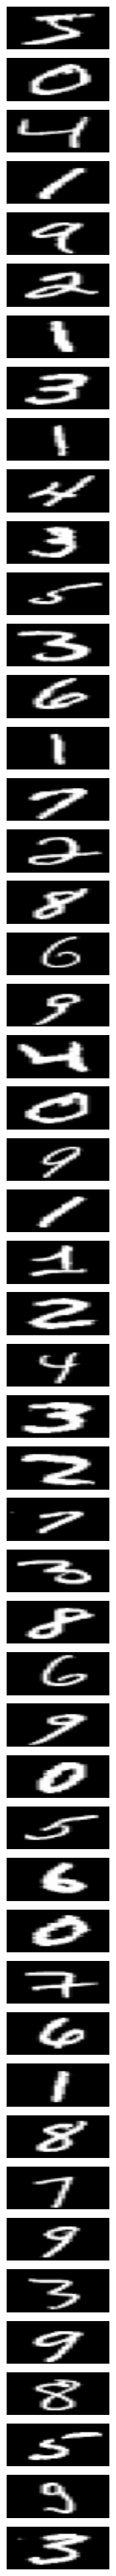

In [ ]:
# here show 50 first of this images
plt.figure(figsize=(2, 50))
for i in range(50):
    ax = plt.subplot(50, 1, i +1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis("off")
    ax.set_aspect('auto')  # Set aspect ratio to auto



plt.show()

PCA is affected by scale, so you need to do some normalization on data before applying PCA.

1- Reshape the data from a 28x28 matrix to a flattened 784-element vector.

2- Subtract the mean and divide by the standard deviation for each sample.


In [ ]:
# Code cell
def normalize_data(x_train_vectorized):
    # Calculate the mean and variance along each feature dimension
    mean = np.mean(x_train_vectorized, axis=0)
    var = np.var(x_train_vectorized, axis=0)

    # Normalize the data using (x - mean) / var
    normalized_x_train=np.zeros(shape=x_train_vectorized.shape)

    #normalized_x_train = (x_train_vectorized - mean) / np.sqrt(var)
    var=var+0.00000001

    for i in range(len(mean)):
          normalized_x_train[:,i]=(x_train_vectorized[:,i] - mean[i]) / np.sqrt(var[i])

    return normalized_x_train

# Example usage




num_samples, img_height, img_width = x_train.shape
x_train_vectorized = x_train.reshape(num_samples, img_height * img_width)


x_train_np_nor=normalize_data(x_train_vectorized)
print(x_train_np_nor.shape)



(60000, 784)


In this section, first obtain the covariance matrix of the data and then extract its eigenvalues and eigenvectors. Finally, sort the eigenvalues and their corresponding eigenvectors from largest to smallest.

In [ ]:
# Code cell
cov_matrix=np.matmul(x_train_np_nor.T,x_train_np_nor)

print(cov_matrix.shape)



(784, 784)


Now, we want to examine how many components can represent 75 percent of the total variance of the data. Note that the variance of each component corresponds to its eigenvalue.

In [ ]:
# Code cell

def components_for_variance(cov_matrix, target_variance=0.75):
    # Compute eigenvalues and eigenvectors
    eigenvalues, Q = np.linalg.eig(cov_matrix)
    print(Q.shape)
    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]

    # Compute explained variance ratio
    explained_variance_ratio = sorted_eigenvalues**2 / np.sum(sorted_eigenvalues**2)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Find the number of components needed
    num_components = np.argmax(cumulative_variance >= target_variance) + 1

    U,S,V=compress_by_k(num_components,Q.copy(),np.diag(eigenvalues),Q.T.copy())

    return num_components,U,S
num_components,Q,S=components_for_variance(cov_matrix,0.75)
print(num_components)



(784, 784)
10


Now in this section, project the available data onto these components, perform dimensionality reduction, and then return the dimensions to the size of the original images. Draw an image of one of the samples for both states: before dimension reduction on the components and after it.

In [ ]:
# Code cell



projected,rebuilt=do_pca2(num_components, x_train_np_nor)







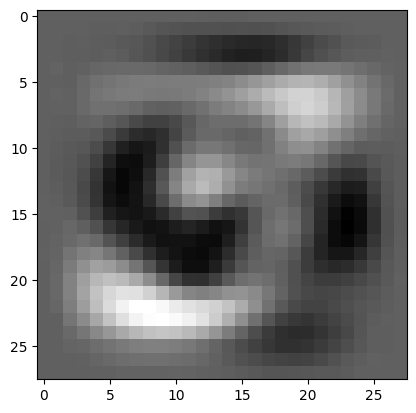

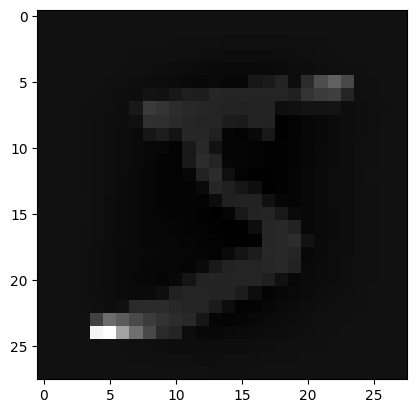

In [ ]:
plt.figure()
plt.imshow( rebuilt[0,:].reshape(28,28),cmap='gray')
plt.figure()

plt.imshow( x_train_np_nor[0,:].reshape(28,28),cmap='gray')


In this section, define a classifier such as SVM or RandomForest, and use the test and training data to determine the accuracy of the classifier. Repeat this process for different numbers of components and examine the impact of increasing the number of components on accuracy. Note that in this section, you can use built-in functions for performing PCA and classification. Additionally, identify which number of components results in the best accuracy.
<br>
<br>
In the plots, we observe that accuracy improves as we increase the dimensionality of the data. However, beyond 10-15 dimensions, the accuracy gains are minimal compared to the computational cost. Therefore, choosing 15-20 dimensions strikes a reasonable balance between accuracy and resource efficiency


In [ ]:
# define a function that calculate PCA
def do_pca(n_components, data):
  cov_matrix=np.matmul(data.T,data)
  eigenvalues, Q = np.linalg.eig(cov_matrix)
  projected=np.zeros(shape=(len((data)),n_components))
  for i in range(len(data)):
    for j in range(n_components):
      projected[i,j]=np.matmul(Q[:,j].T,data[i,:])

  return projected
def do_pca2(n_components, data):
  cov_matrix=np.matmul(data.T,data)
  eigenvalues, Q = np.linalg.eig(cov_matrix)
  rebuilt=np.zeros(shape=data.shape)
  projected=np.zeros(shape=(len((data)),n_components))
  for i in range(len(data)):
    for j in range(n_components):
      projected[i,j]=np.matmul(Q[:,j].T,data[i,:])
  for i in range(len(projected)):
    for j in range(n_components):
      rebuilt[i,:]=rebuilt[i,:]+projected[i,j]*Q[:,j].T


  return projected ,rebuilt

In [ ]:
#define a function that gets the X data and Y labels and returns the accuracy of ml model.
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def ML_model(X, y, print_output=True):
    print(X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the classifier
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_classifier.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    if(print_output):
      print(f"Accuracy: {accuracy:.4f}")
    return accuracy
ks=[2,5,10,15,20,25,30,40,50,60]
accuracies=[]
for i in ks:
  accuracies=accuracies+[ML_model(do_pca(i,x_train_np_nor), y_train,True)]
  print(i)
accuracy = ML_model(projected, y_train,True)



(60000, 2)
Accuracy: 0.3127
2
(60000, 5)
Accuracy: 0.7601
5
(60000, 10)
Accuracy: 0.9029
10
(60000, 15)
Accuracy: 0.9262
15
(60000, 20)
Accuracy: 0.9356
20
(60000, 25)
Accuracy: 0.9356
25
(60000, 30)
Accuracy: 0.9396
30
(60000, 40)
Accuracy: 0.9447
40
(60000, 50)
Accuracy: 0.9458
50
(60000, 60)
Accuracy: 0.9441
60
(60000, 10)
Accuracy: 0.9029


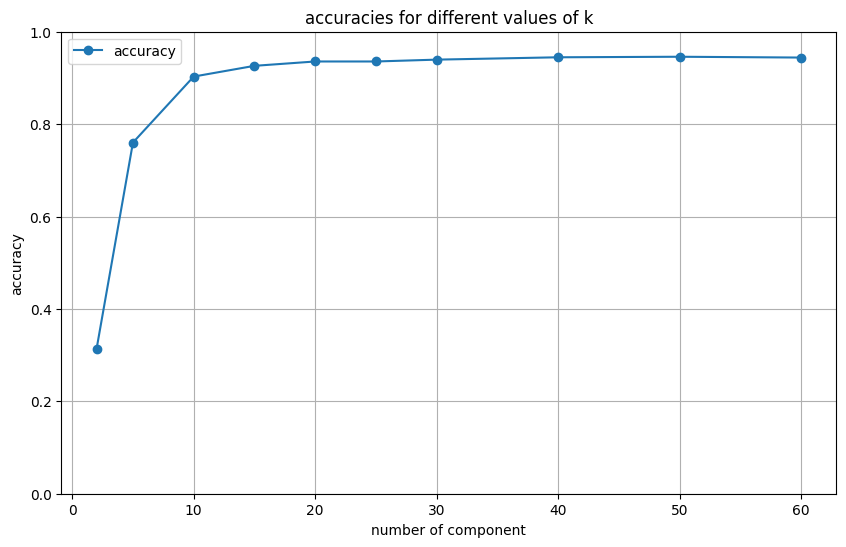

In [ ]:
#your code to plot the accuracy of projected train data on one ml model(choose on your own reggression , random forest , ...)
#consider number of component from 2 to 101 and calculate accuracy based on number of components
plot_multiple_r2_on_same_axis(ks,[np.array(accuracies)],['accuracy'],[0,1],'number of component','accuracy','accuracies for different values of k',0)
